| $k~[h/{\rm Mpc}]$ | Approx. mass scale $M(k) [M_\odot/h]$ | Corresponding structure    |
| ----------------: | ------------------------------------: | -------------------------- |
|               0.1 |                   $3.6\times10^{15}$| cluster scales             |
|                 1 |                   $3.6\times10^{12}$| $L_*$ galaxy halo          |
|                10 |                   $3.6\times10^{9}$| dwarf / small subhalo      |
|               100 |                   $3.6\times10^{6}$| very small DM subhalo      |
|              1000 |                   $3.6\times10^{3}$| Earth-mass microhalo scale |


In [1]:
import numpy as np
from scipy.integrate import simpson
from scipy.special import sici

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis
from matplotlib.colors import LogNorm

from colossus.cosmology import cosmology as colossus_cosmo
from colossus.lss import mass_function,bias

from sashimi_c import *

from DES_CDM1 import *
c = cosmology()
hm = halo_model()

kmin = 1.00e-03 1/Mpc, kmax = 1.00e+05 1/Mpc
zmin = 0.00, zmax = 6.00


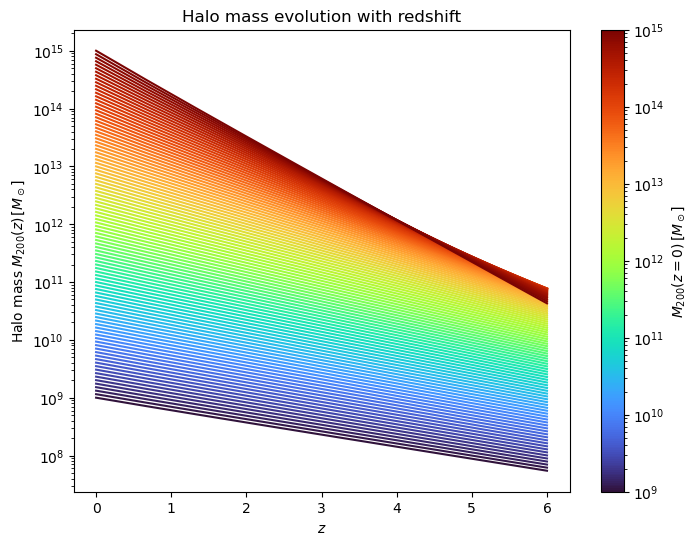

In [39]:
nk=100
nM=100
nz=10

k_grid = np.logspace(-3,5,nk)
kmin = k_grid.min()
kmax = k_grid.max()
print(f'kmin = {kmin:.2e} 1/Mpc, kmax = {kmax:.2e} 1/Mpc')

M_grid = np.logspace(9.0, 15.0, nM) #Masses at z=0

z_grid = np.linspace(0.0,6.0,nz)
zmin = z_grid.min()
zmax = z_grid.max()
print(f'zmin = {zmin:.2f}, zmax = {zmax:.2f}')

Mz_grid = np.zeros((nM,nz),dtype=float) #Masses at different redshifts
for z_id,z in enumerate(z_grid):
    for M_id,M in enumerate(M_grid):
        Mz_grid[M_id][z_id] = hm.Mzi(M,z)


fig, ax = plt.subplots(figsize=(8, 6))
norm = LogNorm(vmin=M_grid.min(), vmax=M_grid.max())
cmap = plt.cm.turbo

for M_id in range(0, nM):
    ax.plot(
        z_grid,
        Mz_grid[M_id, :],
        color=cmap(norm(M_grid[M_id]))
    )

ax.set_yscale('log')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'Halo mass $M_{200}(z)\,[M_\odot]$')
ax.set_title(r'Halo mass evolution with redshift')

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r'$M_{200}(z=0)\,[M_\odot]$')

plt.show()

In [40]:
ps = power_spectrum(zmin=zmin, zmax=zmax,kmin=kmin+1e-8,kmax=kmax-1e-8)
logP_interp_colossus = ps.get_logPmm_interp()

kmin = 1.000e-03, kmax = 1.000e+05, chimin = 0.000e+00, chimax = 8.424e+03, zmin = 0.000, zmax = 6.000


Computed Pmm using Colossus


In [42]:
k_camb= np.logspace(-3,3,nk)
ps_camb = power_spectrum(zmin=zmin, zmax=zmax,kmin=k_camb.min()+1e-8,kmax=k_camb.max()-1e-8,use_camb=True)
logP_interp_camb = ps_camb.get_logPmm_interp()


kmin = 1.000e-03, kmax = 1.000e+03, chimin = 0.000e+00, chimax = 8.424e+03, zmin = 0.000, zmax = 6.000
Note: redshifts have been re-sorted (earliest first)
Computed Pmm using CAMB


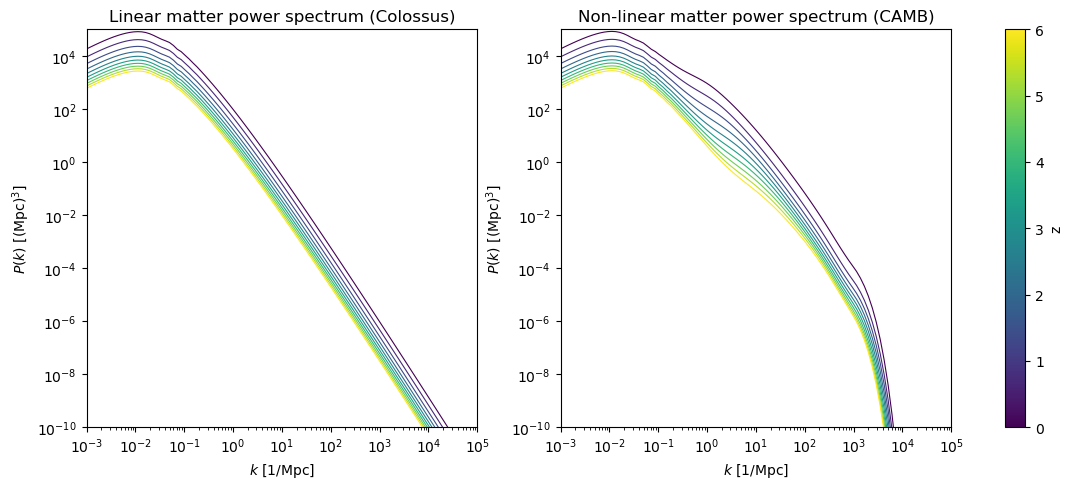

In [44]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
cmap = viridis
norm = Normalize(vmin=zmin, vmax=zmax)

P_lin_zk = np.zeros((nz,nk),dtype=float)
for z_id,z in enumerate(z_grid):
    P_lin_zk[z_id,:] = np.exp(logP_interp_colossus((z, k_grid)))

for z_id,z in enumerate(z_grid):
    Pk = P_lin_zk[z_id,:]
    ax[0].loglog(k_grid, Pk, color=viridis(norm(z)), lw=0.8)  
    Pk_camb = np.exp(logP_interp_camb((z, k_grid)))
    ax[1].loglog(k_grid, Pk_camb, color=viridis(norm(z)), lw=0.8)

ax[0].set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax[0].set_ylabel(r'$P(k)\ [(\mathrm{Mpc})^3]$')
ax[0].set_title('Linear matter power spectrum (Colossus)')
ax[0].set_xlim(kmin, kmax)
ax[0].set_ylim(1e-10, 1e5)
ax[1].set_xlim(kmin, kmax)
ax[1].set_ylim(1e-10, 1e5)
ax[1].set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax[1].set_ylabel(r'$P(k)\ [(\mathrm{Mpc})^3]$')
ax[1].set_title('Non-linear matter power spectrum (CAMB)')

plt.tight_layout()

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('z')
plt.show()

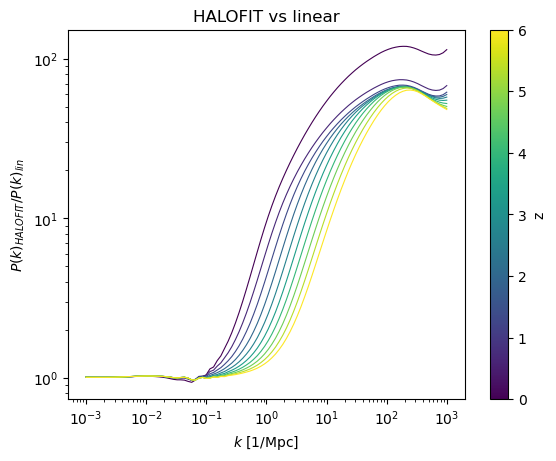

In [45]:
fig, ax = plt.subplots()
cmap = viridis
norm = Normalize(vmin=zmin, vmax=zmax)

for z in z_grid:
    Pk_camb = np.exp(logP_interp_camb((z,k_camb)))
    Pk = np.exp(logP_interp_colossus((z, k_camb)))
    ax.loglog(k_camb, Pk_camb/Pk, color=viridis(norm(z)), lw=0.8)  
ax.set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax.set_ylabel(r'$P(k)_{HALOFIT}/P(k)_{lin}$')
ax.set_title('HALOFIT vs linear')

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('z')
plt.show()

$\bar{\rho} = \int M n(M) dM$

In [7]:
dndlnM_mz = np.zeros((nM,nz))
rho = np.zeros(nz)

for z_id in range(nz):   
        dndlnM_mz[:,z_id] = mass_function.massFunction(Mz_grid[:,z_id]*c.h, z_grid[z_id], mdef='200m', model='tinker08', q_out='dndlnM')/c.h**3
        rho[z_id] = np.trapezoid(Mz_grid[:,z_id] * dndlnM_mz[:,z_id], np.log(Mz_grid[:,z_id]))

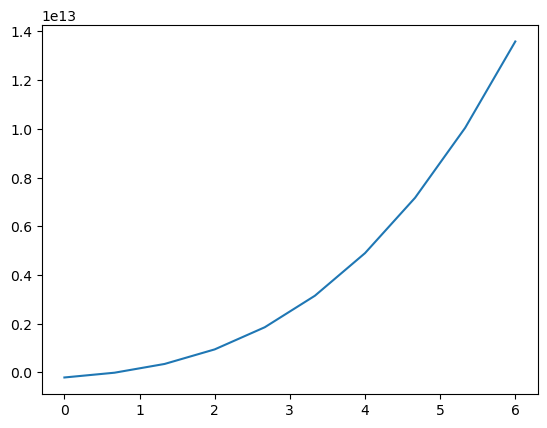

In [10]:
plt.plot(z_grid,c.rho_mean(z_grid)-rho)

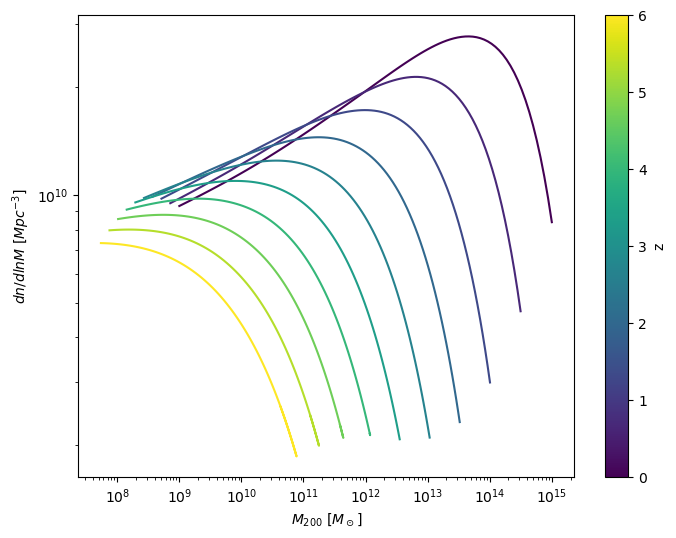

In [11]:
fig, ax = plt.subplots(figsize=(8,6))

norm = plt.Normalize(z_grid.min(), z_grid.max())
cmap = plt.cm.viridis

for z_id, z in enumerate(z_grid):
    ax.plot(
        Mz_grid[:, z_id],
        Mz_grid[:,z_id]*dndlnM_mz[:, z_id],
        color=cmap(norm(z))
    )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$M_{200}$ $[M_\odot]$')
ax.set_ylabel(r'$dn/dlnM$ $[Mpc^{-3}]$')

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('z')

plt.show()

In [8]:
b_mz = np.zeros((nM,nz))
rho_b = np.zeros(nz)
for z_id in range(nz):   
        b_mz[:,z_id] = bias.haloBias(Mz_grid[:,z_id]*c.h, z_grid[z_id], '200m', model = 'tinker10') 
        rho_b[z_id] = np.trapezoid(Mz_grid[:,z_id] * dndlnM_mz[:,z_id]*b_mz[:,z_id], np.log(Mz_grid[:,z_id]))

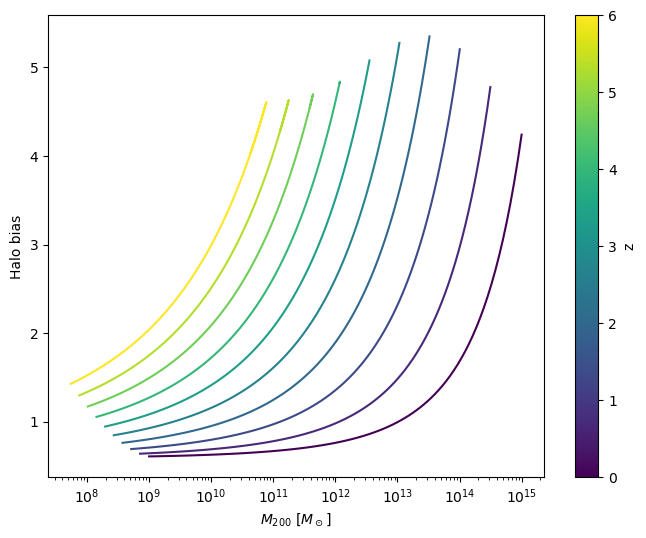

In [13]:
fig, ax = plt.subplots(figsize=(8,6))

norm = plt.Normalize(z_grid.min(), z_grid.max())
cmap = plt.cm.viridis

for z_id, z in enumerate(z_grid):
    ax.plot(
        Mz_grid[:, z_id],
        b_mz[:, z_id],
        color=cmap(norm(z))
    )

ax.set_xscale('log')
ax.set_xlabel(r'$M_{200}$ $[M_\odot]$')
ax.set_ylabel('Halo bias')

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('z')

plt.show()

$\bar{\rho} = \int M n(M) b(M) dM$

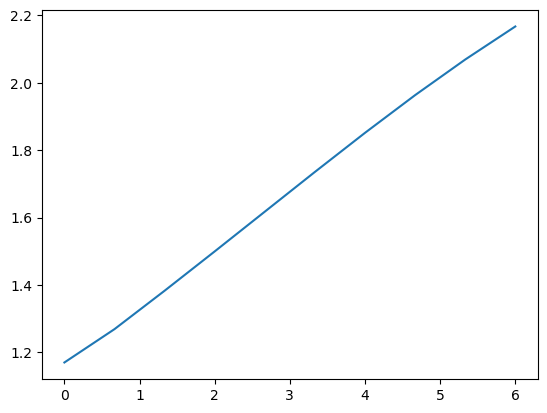

In [14]:
plt.plot(z_grid,rho_b/rho)

# Fourier Transform of the NFW Profile (M₍₂₀₀₎ Convention)

For a spherical NFW density profile,

$$
\rho(r) = \frac{\rho_s}{(r/r_s)\,(1 + r/r_s)^2},
$$

with scale radius $r_s$ and concentration $c = r_{200}/r_s$, the total mass inside $r_{200}$ is

$$
M_{200} = 4\pi \rho_s r_s^3 \left[\ln(1 + c) - \frac{c}{1 + c}\right].
$$

---

## Normalized Fourier Transform

The **mass-normalized** Fourier-space profile is defined as

$$
u(k|M_{200}) = \frac{1}{M_{200}} \int_0^{r_{200}} 4\pi r^2
\frac{\sin(kr)}{kr}\,\rho(r)\,dr,
$$

which has the analytic expression (Cooray & Sheth 2002; Scoccimarro et al. 2001):

$$
u(k|M_{200}) =
\frac{1}{\ln(1 + c) - \dfrac{c}{1 + c}}
\Bigg[
\cos(kr_s)\big[\mathrm{Ci}((1 + c)kr_s) - \mathrm{Ci}(kr_s)\big]
+ \sin(kr_s)\big[\mathrm{Si}((1 + c)kr_s) - \mathrm{Si}(kr_s)\big]
- \frac{\sin(c\,kr_s)}{(1 + c)\,kr_s}
\Bigg],
$$

where

$$
\mathrm{Si}(x) = \int_0^x \frac{\sin t}{t}\,dt, \quad
\mathrm{Ci}(x) = -\int_x^\infty \frac{\cos t}{t}\,dt.
$$

This function is **dimensionless and normalized** such that $u(k \to 0) = 1$.

In [9]:
def u_nfw(k, c, rs):
    """
    Normalized Fourier transform u(k|M_200) of an NFW halo.
    
    Parameters
    ----------
    k : float or array_like
        Wavenumber (same inverse length unit as rs, e.g. h/Mpc if rs in Mpc/h)
    rs : float
        NFW scale radius (Mpc/h)
    c : float
        Concentration parameter (r_200 / r_s)
    
    Returns
    -------
    u : array_like
        Normalized Fourier-space NFW profile (u(0)=1).
    """
    k = np.atleast_1d(k).astype(float)
    x = k * rs
    denom = np.log(1.0 + c) - c / (1.0 + c)
    
    # sine and cosine integrals
    Si_x, Ci_x = special.sici(x)
    Si_xc, Ci_xc = special.sici((1.0 + c) * x)
    
    u = (np.cos(x) * (Ci_xc - Ci_x)
         + np.sin(x) * (Si_xc - Si_x)
         - np.sin(c * x) / ((1.0 + c) * x)) / denom

    return u if u.size > 1 else u.item()

def u_nfw_num(k, c,rs):
    """
    Numerical Fourier transform of the NFW density profile (mass-normalized).
    
    """
    rt = c * rs
    r = np.logspace(-6, np.log10(rt), 2000) 

    x = r / rs
    rho = 1.0 / (x * (1 + x)**2) 

    M = np.trapezoid(4 * np.pi * r**2 * rho, r)

    u = np.zeros_like(k, dtype=float)

    for i, ki in enumerate(k):
        sinc = np.sin(ki * r) / (ki * r)
        integrand = 4 * np.pi * r**2 * rho * sinc
        u[i] = np.trapezoid(integrand, r) / M
        
    return u

In [10]:
def c200_r200_rs(M,z,hm):
    c200 = hm.conc200(M,z)
    r200  = (3.0*M/(4*np.pi*200*hm.rhocrit(z)))**(1./3.)
    rs = r200/c200
    return c200, r200, rs

In [49]:
u_kmz = np.zeros((nk,nM,nz),dtype=float)
for z_id,z in enumerate(z_grid):
    for M_id,M in enumerate(M_grid):
        c200, r200, rs = c200_r200_rs(Mz_grid[M_id][z_id],z,hm)
        u_kmz[:,M_id,z_id] = u_nfw(k_grid, c200, rs)

In [48]:
u_kmz_num = np.zeros((nk,nM,nz),dtype=float)
for z_id,z in enumerate(z_grid):
    for M_id,M in enumerate(M_grid):
        c200, r200, rs = c200_r200_rs(Mz_grid[M_id][z_id],z,hm)
        u_kmz_num[:,M_id,z_id] = u_nfw_num(k_grid, c200, rs)

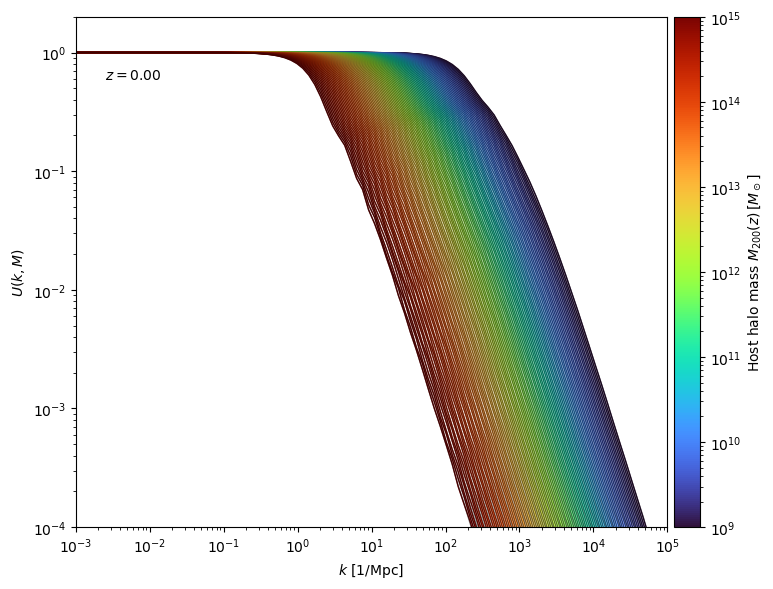

In [50]:
z_id = 0
fig, ax = plt.subplots(figsize=(8,6))
norm = LogNorm(vmin=M_grid.min(), vmax=M_grid.max())
cmap = plt.cm.turbo

for M_id,M in enumerate(M_grid):
    ax.loglog(
        k_grid,
        u_kmz[:,M_id,z_id],
        color=cmap(norm(M)),
        lw=1
    )
    ax.loglog(
        k_grid,
        u_kmz_num[:,M_id,z_id],
        color='black',
        lw=1,
        alpha = 0.5,
    )

ax.set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax.set_ylabel(r'$U(k,M)$')
ax.set_xlim(kmin, kmax)
ax.set_ylim(1e-4, 2e0)

ax.text(
        0.05, 0.90,
        rf'$z={z_grid[z_id]:.2f}$',
        transform=ax.transAxes,
        ha='left',
        va='top'
)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label(r'Host halo mass $M_{200}(z)\,[M_\odot]$')

plt.tight_layout()
plt.show()

In [20]:
fsh_list = np.empty((nM,nz))
m_list = np.empty((nM,nz),dtype=object)
dNdlnm_list = np.empty((nM,nz),dtype=object)
rs0_list = np.empty((nM,nz),dtype=object)
ct0_list = np.empty((nM,nz),dtype=object)

for i,M in enumerate(M_grid):
    for j,z in enumerate(z_grid):
        print(i+1,'/',nM,j+1,'/',nz)
        obs = subhalo_observables(M0_per_Msun=M,redshift=z,M0_at_redshift=False)
        fsh_list[i,j] = obs.mass_fraction(evolved=True)
        m_list[i,j],dNdlnm_list[i,j] = obs.mass_function(evolved=True)
        _, rs0_list[i,j], ct0_list[i,j] = obs.density_parameters(evolved=True)

1 / 100 1 / 10


1 / 100 2 / 10
1 / 100 3 / 10
1 / 100 4 / 10
1 / 100 5 / 10
1 / 100 6 / 10
1 / 100 7 / 10
1 / 100 8 / 10
1 / 100 9 / 10
1 / 100 10 / 10
2 / 100 1 / 10
2 / 100 2 / 10
2 / 100 3 / 10
2 / 100 4 / 10
2 / 100 5 / 10
2 / 100 6 / 10
2 / 100 7 / 10
2 / 100 8 / 10
2 / 100 9 / 10
2 / 100 10 / 10
3 / 100 1 / 10
3 / 100 2 / 10
3 / 100 3 / 10
3 / 100 4 / 10
3 / 100 5 / 10
3 / 100 6 / 10
3 / 100 7 / 10
3 / 100 8 / 10
3 / 100 9 / 10
3 / 100 10 / 10
4 / 100 1 / 10
4 / 100 2 / 10
4 / 100 3 / 10
4 / 100 4 / 10
4 / 100 5 / 10
4 / 100 6 / 10
4 / 100 7 / 10
4 / 100 8 / 10
4 / 100 9 / 10
4 / 100 10 / 10
5 / 100 1 / 10
5 / 100 2 / 10
5 / 100 3 / 10
5 / 100 4 / 10
5 / 100 5 / 10
5 / 100 6 / 10
5 / 100 7 / 10
5 / 100 8 / 10
5 / 100 9 / 10
5 / 100 10 / 10
6 / 100 1 / 10
6 / 100 2 / 10
6 / 100 3 / 10
6 / 100 4 / 10
6 / 100 5 / 10
6 / 100 6 / 10
6 / 100 7 / 10
6 / 100 8 / 10
6 / 100 9 / 10
6 / 100 10 / 10
7 / 100 1 / 10
7 / 100 2 / 10
7 / 100 3 / 10
7 / 100 4 / 10
7 / 100 5 / 10
7 / 100 6 / 10
7 / 100 7 / 10
7 / 

In [12]:
np.savez('subhalo_observables5.npz',fsh_list=fsh_list,
         m_list=m_list,         
         dNdlnm_list=dNdlnm_list,
         rs0_list=rs0_list,
         ct0_list=ct0_list,
)

NameError: name 'fsh_list' is not defined

In [13]:
data = np.load('subhalo_observables5.npz',allow_pickle=True)
fsh_list = data['fsh_list']
m_list = data['m_list']
dNdlnm_list = data['dNdlnm_list']
rs0_list = data['rs0_list']
ct0_list = data['ct0_list']

For a (truncated) NFW profile with characteristic density \( \rho_s \), scale radius
\( r_s \), and truncation radius \( r_t \) (here \( r_t = c_t\, r_s \)), the real-space
density is

$$
\rho(r) =
\begin{cases}
\dfrac{\rho_s}{(r/r_s)\,(1+r/r_s)^2}, & r \le r_t \\
0, & r > r_t \; .
\end{cases}
$$

The 3D Fourier transform of \( \rho(r) \) is

$$
\tilde{\rho}(k)
= 4\pi \int_0^{r_t} r^2 \rho(r)\,
\frac{\sin(kr)}{kr}\, \mathrm{d}r \; .
$$

If you want the mass-normalized halo-model profile \( u(k) \), divide by the mass
inside the truncation radius:

$$
u(k) = \frac{\tilde{\rho}(k)}{M(r_t)} ,
$$

where

$$
M(r_t)
= 4\pi \rho_s r_s^3
\left[\ln(1+c_t) - \frac{c_t}{1+c_t}\right],
\qquad
c_t \equiv \frac{r_t}{r_s}.
$$

There is an analytic expression for the Fourier transform in terms of the sine and
cosine integrals, identical in form to the standard NFW result but with the upper
limit \( k r_t \). Explicitly,

$$
\tilde{\rho}(k)
= 4\pi \rho_s r_s^3 \Big[
\cos(k r_s)\big( \mathrm{Ci}(k r_t) - \mathrm{Ci}(k r_s) \big)
+ \sin(k r_s)\big( \mathrm{Si}(k r_t) - \mathrm{Si}(k r_s) \big)
- \frac{\sin(k r_t)}{k r_t}
\Big].
$$

Thus the normalized Fourier-space profile is

$$
u(k) = \frac{\tilde{\rho}(k)}{M(r_t)} .
$$


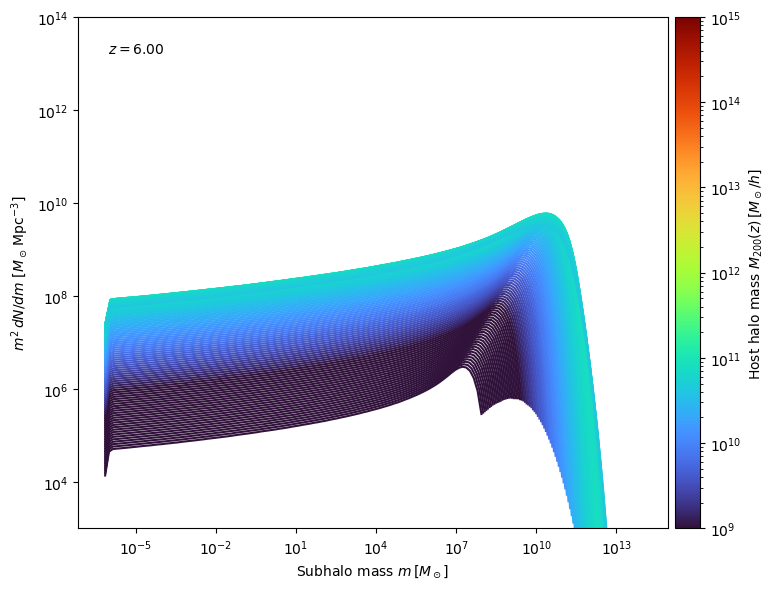

In [51]:
z_id = 9

cmap = plt.cm.turbo
norm = LogNorm(vmin=M_grid.min(), vmax=M_grid.max())

fig, ax = plt.subplots(figsize=(8,6))
for M_id in range(nM):
    m = m_list[M_id][z_id]
    dNdlnm = dNdlnm_list[M_id][z_id]

    color = cmap(norm(Mz_grid[M_id, z_id]))
    ax.loglog(m, m * dNdlnm, color=color)

ax.set_ylabel(r'$m^2\,dN/dm\ [M_\odot\,\mathrm{Mpc}^{-3}]$')
ax.set_xlabel(r'Subhalo mass $m\,[M_\odot]$')

ax.text(
        0.05, 0.95,
        rf'$z={z_grid[z_id]:.2f}$',
        transform=ax.transAxes,
        ha='left',
        va='top'
)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label(r'Host halo mass $M_{200}(z)\,[M_\odot/h]$')

ax.set_ylim(1e3,1e14)
plt.tight_layout()
plt.show()

In [14]:
rs_interp_funcs = [[None for _ in range(nz)] for _ in range(nM)]
rs_interpolated_list = np.empty((nM, nz), dtype=object)
rs_combined_list = np.empty((nM, nz), dtype=object)


ct_interp_funcs = [[None for _ in range(nz)] for _ in range(nM)]
ct_interpolated_list = np.empty((nM, nz), dtype=object)
ct_combined_list = np.empty((nM, nz), dtype=object)

for z_id in range(nz):
    for M_id in range(nM):
        m = m_list[M_id][z_id]
        rs = rs0_list[M_id][z_id]
        ct = ct0_list[M_id][z_id]

        mask = (m > 1e-4) & (m < 1e6)

        rs_interp_funcs[M_id][z_id] = interp1d(
            np.log10(m[mask]),
            np.log10(rs[mask]),
            kind='linear',
            fill_value='extrapolate'
        )

        rs_interpolated_list[M_id, z_id] = 10**rs_interp_funcs[M_id][z_id](np.log10(m))
        rs_combined_list[M_id, z_id] = rs.copy()
        rs_combined_list[M_id, z_id][m > 1e6] = rs_interpolated_list[M_id, z_id][m > 1e6]

        ct_interp_funcs[M_id][z_id] = interp1d(
            np.log10(m[mask]),
            np.log10(ct[mask]),
            kind='linear',
            fill_value='extrapolate'
        )

        ct_interpolated_list[M_id, z_id] = 10**ct_interp_funcs[M_id][z_id](np.log10(m))
        ct_combined_list[M_id, z_id] = ct.copy()
        ct_combined_list[M_id, z_id][m > 1e6] = ct_interpolated_list[M_id, z_id][m > 1e6]



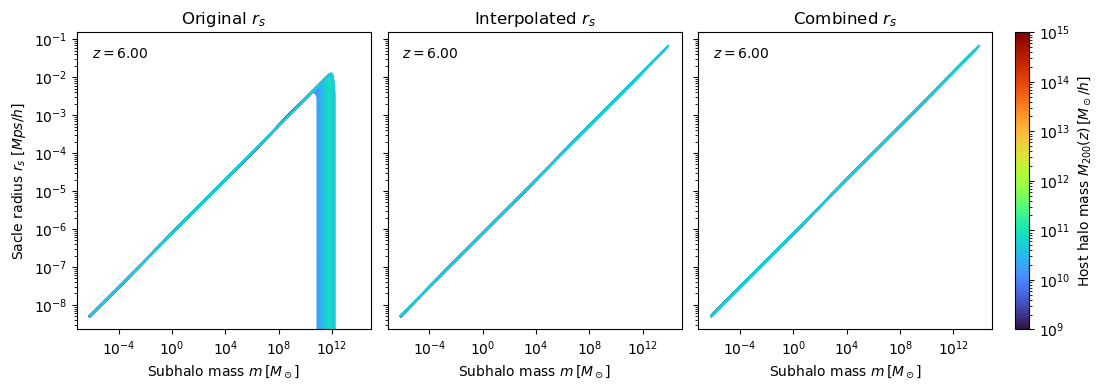

In [23]:
z_id = 9

cmap = plt.cm.turbo
norm = LogNorm(vmin=M_grid.min(), vmax=M_grid.max())

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for M_id in range(nM):
    m = m_list[M_id][z_id]
    color = cmap(norm(Mz_grid[M_id, z_id]))

    # ---- subplot 1: original rs
    axes[0].loglog(m, rs0_list[M_id,z_id], color=color)

    # ---- subplot 2: interpolated rs
    axes[1].loglog(m, rs_interpolated_list[M_id, z_id], color=color)

    # ---- subplot 3: combined rs
    axes[2].loglog(m, rs_combined_list[M_id, z_id], color=color)

# ---- labels & titles
axes[0].set_title(r"Original $r_s$")
axes[1].set_title(r"Interpolated $r_s$")
axes[2].set_title(r"Combined $r_s$")

for ax in axes:
    #ax.set_ylim(1,1e2)
    #ax.set_xlim(1e-10,1e15)
    ax.set_xlabel(r"Subhalo mass $m\,[M_\odot]$")
    ax.text(
        0.05, 0.95,
        rf"$z={z_grid[z_id]:.2f}$",
        transform=ax.transAxes,
        ha="left",
        va="top"
    )
    
axes[0].set_ylabel(r"Sacle radius $r_s$ $[Mps/h]$")

plt.tight_layout()

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, pad=0.02)
cbar.set_label(r"Host halo mass $M_{200}(z)\,[M_\odot/h]$")

plt.show()

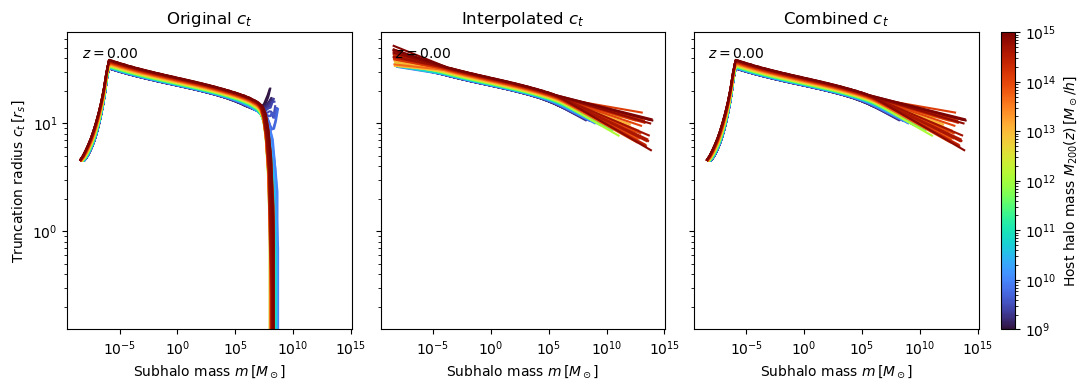

In [25]:
z_id = 0

cmap = plt.cm.turbo
norm = LogNorm(vmin=M_grid.min(), vmax=M_grid.max())

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for M_id in range(nM):
    m = m_list[M_id][z_id]
    color = cmap(norm(Mz_grid[M_id, z_id]))

    # ---- subplot 1: original rs
    axes[0].loglog(m, ct0_list[M_id,z_id], color=color)

    # ---- subplot 2: interpolated rs
    axes[1].loglog(m, ct_interpolated_list[M_id, z_id], color=color)

    # ---- subplot 3: combined rs
    axes[2].loglog(m, ct_combined_list[M_id, z_id], color=color)

# ---- labels & titles
axes[0].set_title(r"Original $c_t$")
axes[1].set_title(r"Interpolated $c_t$")
axes[2].set_title(r"Combined $c_t$")

for ax in axes:
    #ax.set_ylim(1,1e2)
    #ax.set_xlim(1e-10,1e15)
    ax.set_xlabel(r"Subhalo mass $m\,[M_\odot]$")
    ax.text(
        0.05, 0.95,
        rf"$z={z_grid[z_id]:.2f}$",
        transform=ax.transAxes,
        ha="left",
        va="top"
    )
    
axes[0].set_ylabel(r"Truncation radius $c_t\,[r_s]$")

plt.tight_layout()

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, pad=0.02)
cbar.set_label(r"Host halo mass $M_{200}(z)\,[M_\odot/h]$")

plt.show()

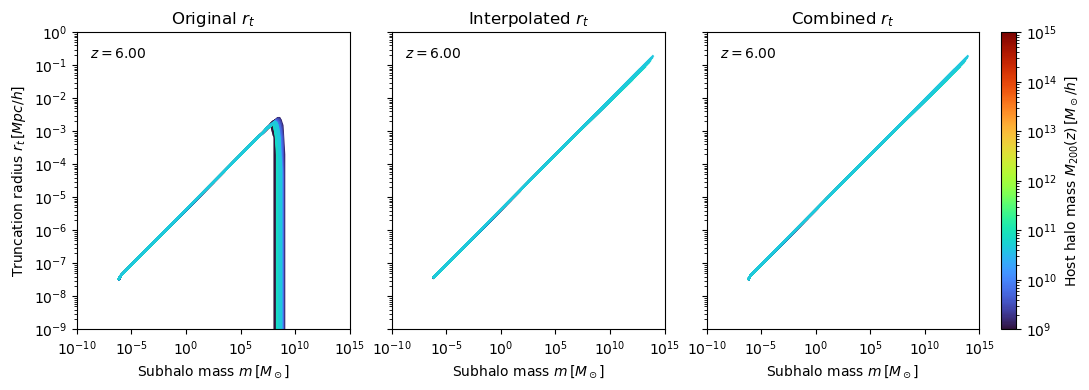

In [25]:
z_id = 9

cmap = plt.cm.turbo
norm = LogNorm(vmin=M_grid.min(), vmax=M_grid.max())

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

for M_id in range(nM):
    m = m_list[M_id][z_id]

    # color by instantaneous host mass
    color = cmap(norm(Mz_grid[M_id, z_id]))

    # ---- subplot 1: original ct
    axes[0].loglog(
        m,
        rs0_list[M_id][z_id]*ct0_list[M_id][z_id],
        color=color,
    )

    # ---- subplot 2: interpolated ct
    axes[1].loglog(
        m,
        rs_interpolated_list[M_id, z_id]*ct_interpolated_list[M_id, z_id],
        color=color,
    )

    # ---- subplot 3: combined CT
    axes[2].loglog(
        m,
        rs_combined_list[M_id, z_id]*ct_combined_list[M_id, z_id],
        color=color,
    )

# Titles
axes[0].set_title(r"Original $r_t$")
axes[1].set_title(r"Interpolated $r_t$")
axes[2].set_title(r"Combined $r_t$")

# Labels + z annotation
for ax in axes:
    ax.set_ylim(1e-9,1)
    ax.set_xlim(1e-10,1e15)
    ax.set_xlabel(r"Subhalo mass $m\,[M_\odot]$")
    ax.text(
        0.05, 0.95,
        rf"$z={z_grid[z_id]:.2f}$",
        transform=ax.transAxes,
        ha="left",
        va="top"
    )

axes[0].set_ylabel(r"Truncation radius $r_t\,[Mpc/h]$")
plt.tight_layout()

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, pad=0.02)
cbar.set_label(r"Host halo mass $M_{200}(z)\,[M_\odot/h]$")

plt.show()

In [15]:
nm = len(m_list[0][0])

In [16]:
um_kmz = np.zeros((nk,nM,nz,nm))

for z_id in range(nz):
    for M_id in range(nM):
        rs = rs0_list[M_id][z_id]
        ct = ct0_list[M_id][z_id]
        for m_id in range(nm):
            um_kmz[:, M_id,z_id,m_id] = u_nfw(k_grid, ct[m_id], rs[m_id])

In [52]:
um_kmz = np.zeros((nk,nM,nz,nm))

for z_id in range(nz):
    for M_id in range(nM):
        rs = rs_combined_list[M_id][z_id]
        ct = ct_combined_list[M_id][z_id]
        for m_id in range(nm):
            um_kmz[:, M_id,z_id,m_id] = u_nfw(k_grid, ct[m_id], rs[m_id])

In [ ]:
um_kmz_num = np.zeros((nk,nM,nz,nm))

for z_id in range(nz):
    for M_id in range(nM):
        print(M_id,z_id)
        rs = rs_combined_list[M_id][z_id]
        ct = ct_combined_list[M_id][z_id]
        for m_id in range(nm):
            um_kmz_num[:, M_id,z_id,m_id] = u_nfw_num(k_grid, ct[m_id], rs[m_id])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1
12 1
13 1
14 1
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
40 1
41 1
42 1
43 1
44 1
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
0 2
1 2
2 2
3 2
4 2


In [ ]:
np.savez('subhalo_um_kmz_num5.npz',um_kmz_num=um_kmz_num)

In [ ]:
um_data = np.load('subhalo_um_kmz_num4.npz')
um_kmz_num = um_data['um_kmz_num'] 

In [30]:
print(np.shape(um_kmz)) # k,M,z,m
print(np.shape(u_kmz)) # k,M,z

(100, 100, 10, 100)
(100, 100, 10)


In [53]:
m_min = 1e20
m_max = 0
for z_id in range(nz):
    for M_id in range(nM):
        m_min1 = m_list[M_id][z_id].min()
        m_max1 = m_list[M_id][z_id].max()
        if m_min1 < m_min:
            m_min = m_min1
        if m_max1 > m_max:
            m_max = m_max1

print(f'min subhalo mass = {m_min:.2e} Msun')
print(f'max subhalo mass = {m_max:.2e} Msun')

min subhalo mass = 4.09e-09 Msun
max subhalo mass = 9.02e+13 Msun


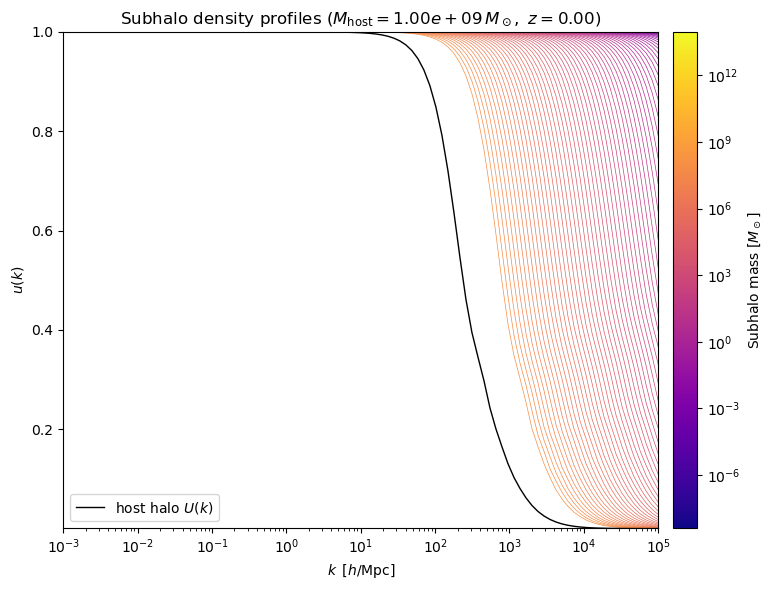

In [54]:
M_id = 0
z_id = 0

cmap = plt.cm.plasma
norm = LogNorm(vmin=m_min, vmax=m_max)


fig, ax = plt.subplots(figsize=(8,6))

for m_id in range(nm):
    um = um_kmz[:,M_id,z_id,m_id]
    m = m_list[M_id][z_id][m_id]
    color = cmap(norm(m))
    ax.plot(k_grid, um, lw=0.5, color=color)
ax.plot(k_grid, u_kmz[:,M_id,z_id], lw=1, color='black', label="host halo $U(k)$")

ax.set_xscale('log')
#ax.set_yscale('log')

ax.set_xlabel(r"$k\ \,[h/{\rm Mpc}]$")
ax.set_ylabel(r"$u(k)$")

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label(r"Subhalo mass $[M_\odot]$")

ax.set_title(
    rf"Subhalo density profiles "
    rf"($M_{{\mathrm{{host}}}} = {Mz_grid[M_id, z_id]:.2e}\,M_\odot,\ z = {z_grid[z_id]:.2f}$)")

ax.legend(loc = 'lower left')
ax.set_xlim(kmin, kmax)
ax.set_ylim(1e-3, 1)

plt.tight_layout()
plt.show()

In [55]:
P_1h = np.zeros((nz,nk))

for z_id, z in enumerate(z_grid):
    for k_id, k in enumerate(k_grid):
        integrand = ( Mz_grid[:,z_id] / rho_b[z_id] ) **2 * dndlnM_mz[:,z_id] * u_kmz[k_id,:,z_id]**2
        P_1h[z_id,k_id] = simpson(integrand,np.log(Mz_grid[:,z_id]))    

In [56]:
P_2h = np.zeros((nz,nk))

for z_id, z in enumerate(z_grid):
    for k_id, k in enumerate(k_grid):
        b = bias.haloBias(Mz_grid[:,z_id]*c.h, z, '200m', model = 'tinker10')
        Plin = P_lin_zk[z_id,k_id]
        integrand =  ( Mz_grid[:,z_id] / rho_b[z_id] ) * dndlnM_mz[:,z_id]  * b * u_kmz[k_id,:,z_id]
        integral = simpson(integrand, np.log(Mz_grid[:,z_id]))
        P_2h[z_id,k_id] = Plin * integral**2

In [57]:
P_hh_total = P_1h + P_2h

In [58]:
np.savez('standard_halo_model_power_spectra04.npz', k=k_grid, z=z_grid, P_1h=P_1h, P_2h=P_2h,P_hh_total =P_hh_total)

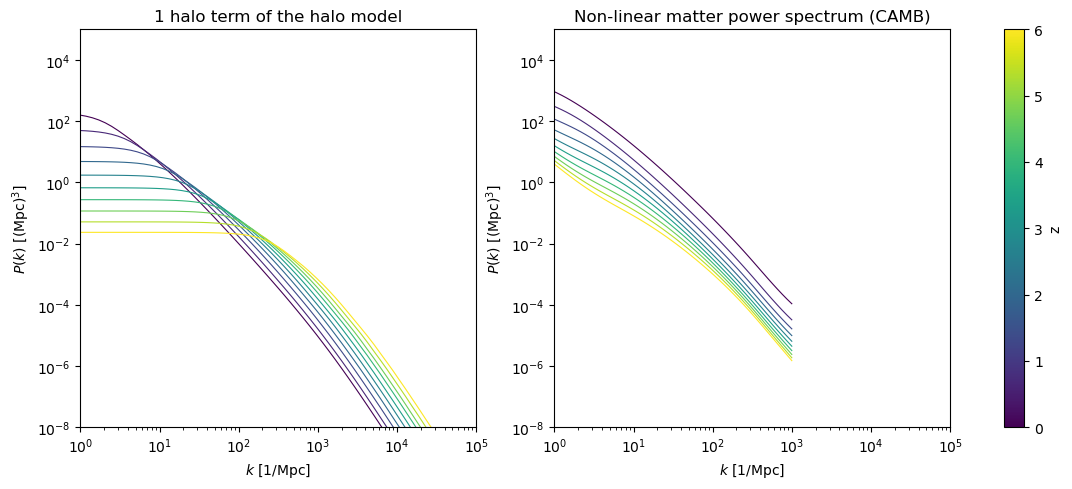

In [59]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
cmap = viridis
norm = Normalize(vmin=zmin, vmax=zmax)

for z_id,z in enumerate(z_grid):
    Pk = P_lin_zk[z_id,:]
    ax[0].loglog(k_grid, P_1h[z_id,:], color=viridis(norm(z)), lw=0.8)  
    Pk_camb = np.exp(logP_interp_camb((z, k_camb)))
    ax[1].loglog(k_camb, Pk_camb, color=viridis(norm(z)), lw=0.8)

ax[0].set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax[0].set_ylabel(r'$P(k)\ [(\mathrm{Mpc})^3]$')
ax[0].set_title('1 halo term of the halo model')
ax[0].set_xlim(1, kmax)
ax[0].set_ylim(1e-8, 1e5)
ax[1].set_xlim(1, kmax)
ax[1].set_ylim(1e-8, 1e5)
ax[1].set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax[1].set_ylabel(r'$P(k)\ [(\mathrm{Mpc})^3]$')
ax[1].set_title('Non-linear matter power spectrum (CAMB)')

plt.tight_layout()

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('z')
plt.show()

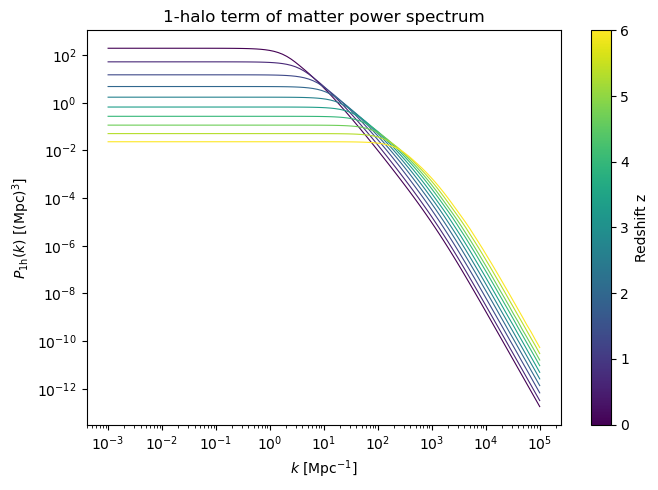

In [60]:
fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$P_{\rm 1h}(k)$ [$(\mathrm{Mpc})^3$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('1-halo term of matter power spectrum')

# Colormap for redshift
cmap = viridis
norm = Normalize(vmin=np.min(z_grid), vmax=np.max(z_grid))

# Plot each redshift with corresponding color
for i, z in enumerate(z_grid):
    ax.plot(k_grid, P_1h[i,:], color=cmap(norm(z)), lw=0.8)

# Add colorbar for redshift
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Redshift z')

plt.tight_layout()
plt.show()

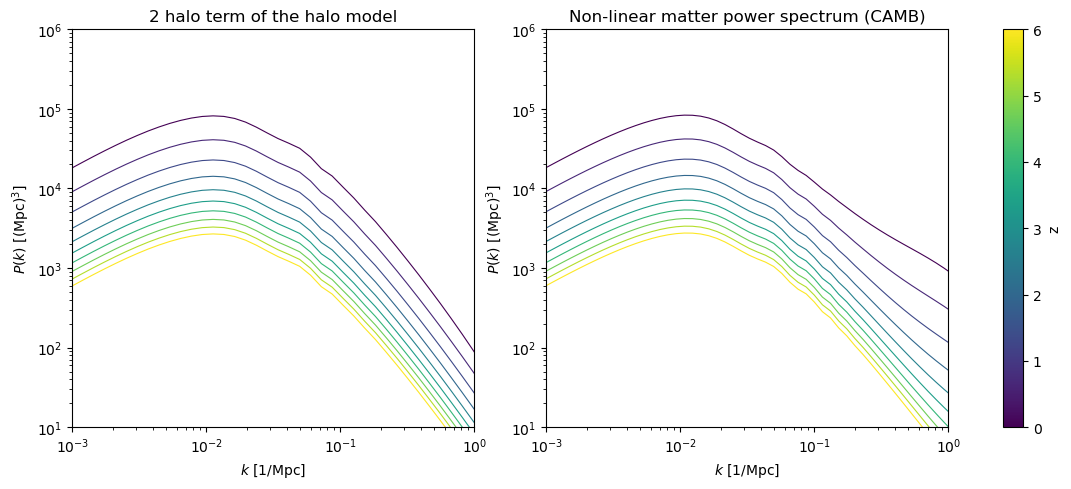

In [61]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
cmap = viridis
norm = Normalize(vmin=zmin, vmax=zmax)

for z_id,z in enumerate(z_grid):
    Pk = P_lin_zk[z_id,:]
    ax[0].loglog(k_grid, P_2h[z_id,:], color=viridis(norm(z)), lw=0.8)  
    Pk_camb = np.exp(logP_interp_camb((z, k_camb)))
    ax[1].loglog(k_camb, Pk_camb, color=viridis(norm(z)), lw=0.8)

ax[0].set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax[0].set_ylabel(r'$P(k)\ [(\mathrm{Mpc})^3]$')
ax[0].set_title('2 halo term of the halo model')
ax[0].set_xlim(kmin, 1)
ax[0].set_ylim(1e1, 1e6)
ax[1].set_xlim(kmin, 1)
ax[1].set_ylim(1e1, 1e6)
ax[1].set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax[1].set_ylabel(r'$P(k)\ [(\mathrm{Mpc})^3]$')
ax[1].set_title('Non-linear matter power spectrum (CAMB)')

plt.tight_layout()

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('z')
plt.show()

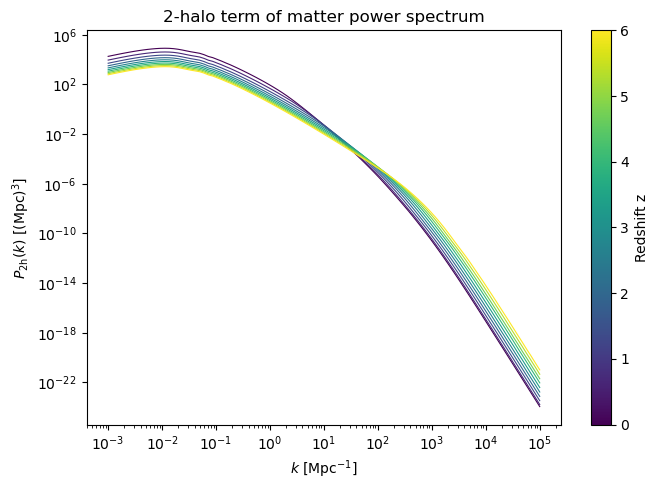

In [62]:
fig, ax = plt.subplots(figsize=(7,5))

ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$P_{\rm 2h}(k)$ [$(\mathrm{Mpc})^3$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('2-halo term of matter power spectrum')

# Colormap for redshift
cmap = viridis
norm = Normalize(vmin=np.min(z_grid), vmax=np.max(z_grid))

# Plot each redshift with corresponding color
for i, z in enumerate(z_grid):
    ax.plot(k_grid, P_2h[i,:], color=cmap(norm(z)), lw=0.8)

# Add colorbar for redshift
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Redshift z')

plt.tight_layout()
plt.show()

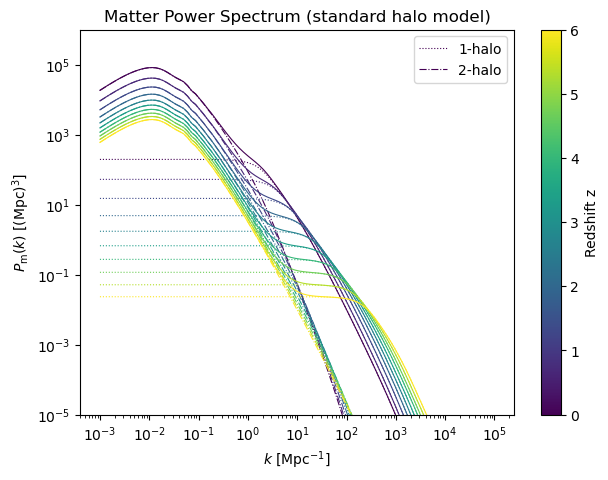

In [63]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_title('Matter Power Spectrum (standard halo model)')
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$P_{\rm m}(k)$ [$(\mathrm{Mpc})^3$]')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-5,1e6)

# Colormap for redshift
cmap = viridis
norm = Normalize(vmin=np.min(z_grid), vmax=np.max(z_grid))

for i,z in enumerate(z_grid):
    ax.plot(k_grid, P_hh_total[i,:], color=cmap(norm(z)), lw=0.8)
    ax.plot(k_grid, P_1h[i,:], ls=':', color=cmap(norm(z)), lw=0.8, label='1-halo')
    ax.plot(k_grid, P_2h[i,:], ls='-.', color=cmap(norm(z)), lw=0.8, label='2-halo')
    if i==0:
        ax.legend()

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Redshift z')

plt.show()

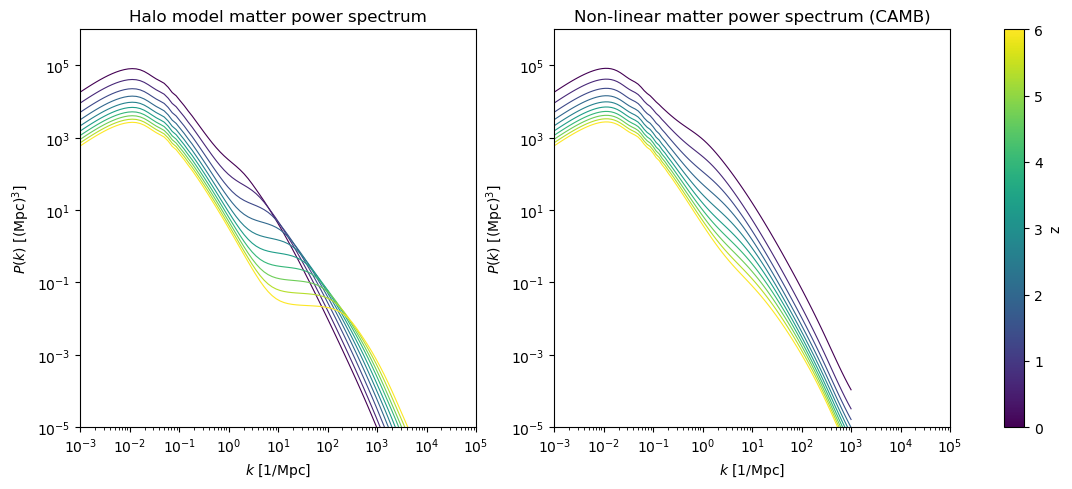

In [64]:
fig, ax = plt.subplots(1,2, figsize=(12, 5))
cmap = viridis
norm = Normalize(vmin=zmin, vmax=zmax)

for z_id,z in enumerate(z_grid):
    ax[0].loglog(k_grid, P_hh_total[z_id,:], color=viridis(norm(z)), lw=0.8)  
    Pk_camb = np.exp(logP_interp_camb((z, k_camb)))
    ax[1].loglog(k_camb, Pk_camb, color=viridis(norm(z)), lw=0.8)

ax[0].set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax[0].set_ylabel(r'$P(k)\ [(\mathrm{Mpc})^3]$')
ax[0].set_title('Halo model matter power spectrum')
ax[0].set_xlim(kmin, kmax)
ax[0].set_ylim(1e-5, 1e6)
ax[1].set_xlim(kmin, kmax)
ax[1].set_ylim(1e-5, 1e6)
ax[1].set_xlabel(r'$k\ [1/\mathrm{Mpc}]$')
ax[1].set_ylabel(r'$P(k)\ [(\mathrm{Mpc})^3]$')
ax[1].set_title('Non-linear matter power spectrum (CAMB)')

plt.tight_layout()

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('z')
plt.show()

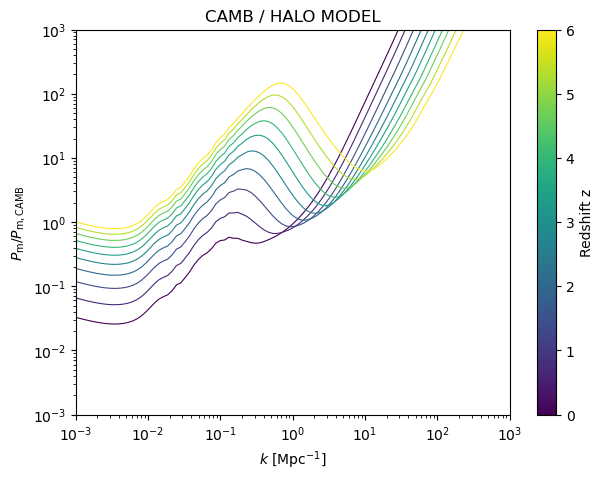

In [67]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_title('CAMB / HALO MODEL')
ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$')
ax.set_ylabel(r'$P_{\rm m}/P_{\rm m,CAMB}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3,1e3)
ax.set_xlim(k_camb.min(),k_camb.max())

# Colormap for redshift
cmap = viridis
norm = Normalize(vmin=np.min(z_grid), vmax=np.max(z_grid))

for i,z in enumerate(z_grid):
    ax.plot(k_camb, Pk_camb/P_hh_total[i,:], color=cmap(norm(z)), lw=0.8)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Redshift z')

plt.show()

In [29]:
def I_func(M,m,dNdlnm,u):
    integrand_values = m/M * u * dNdlnm
    return simpson(integrand_values,np.log(m))

def J_func(M,m,dNdlnm,u):
    integrand_values = (m/M)**2 *  u**2 * dNdlnm
    return simpson(integrand_values,np.log(m))

In [68]:
I_list = np.zeros((nk,nM,nz))
for M_id in range(nM):
    for k_id in range(nk):
        for z_id in range(nz):
            um = um_kmz[k_id,M_id,z_id,:]       
            M = Mz_grid[M_id,z_id]
            m = m_list[M_id,z_id]
            dNdlnm = dNdlnm_list[M_id,z_id]
            I_list[k_id,M_id,z_id] = I_func(M,m,dNdlnm,um)

In [69]:
J_list = np.zeros((nk,nM,nz))
for M_id in range(nM):
    for k_id in range(nk):
        for z_id in range(nz):
            um = um_kmz[k_id,M_id,z_id,:]       
            M = Mz_grid[M_id,z_id]
            m = m_list[M_id,z_id]
            dNdlnm = dNdlnm_list[M_id,z_id]
            J_list[k_id,M_id,z_id] = J_func(M,m,dNdlnm,um)

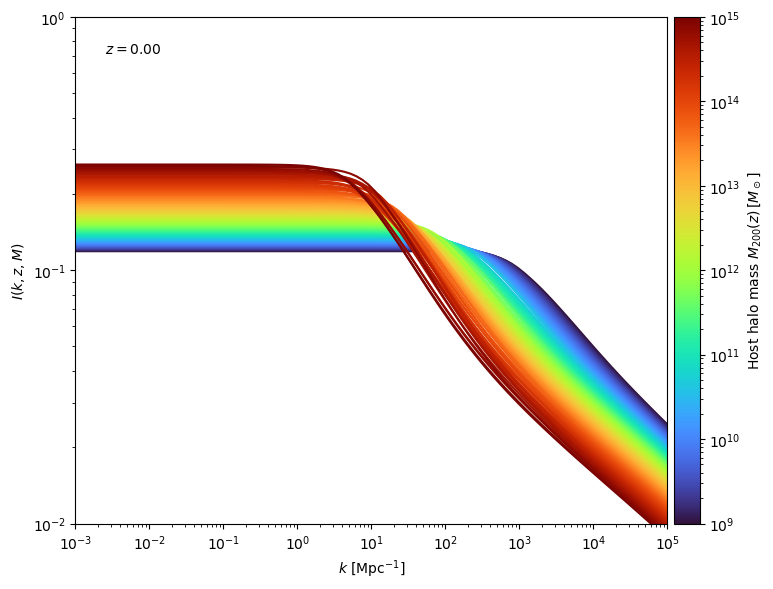

In [70]:
z_id = 0

cmap = plt.cm.turbo
norm = LogNorm(vmin=M_grid.min(), vmax=M_grid.max())

fig, ax = plt.subplots(figsize=(8,6))
for M_id in range(nM):
    I = I_list[:,M_id,z_id]
    color = cmap(norm(Mz_grid[M_id, z_id]))
    ax.loglog(k_grid,I, color=color)

ax.set_ylabel(r'$I(k,z,M)$')
ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$')

ax.text(
        0.05, 0.95,
        rf'$z={z_grid[z_id]:.2f}$',
        transform=ax.transAxes,
        ha='left',
        va='top'
)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label(r'Host halo mass $M_{200}(z)\,[M_\odot]$')

ax.set_xlim(kmin,kmax)
ax.set_ylim(1e-2,1)
plt.tight_layout()
plt.show()

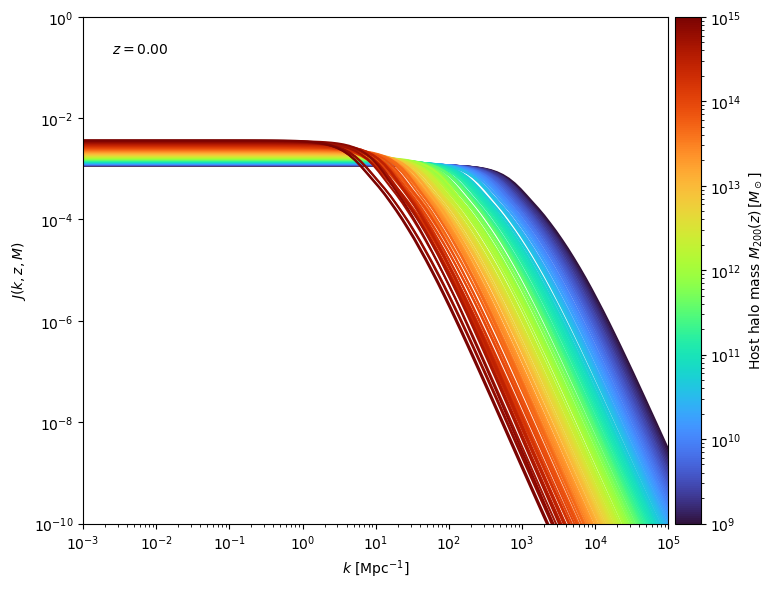

In [71]:
z_id = 0

cmap = plt.cm.turbo
norm = LogNorm(vmin=M_grid.min(), vmax=M_grid.max())

fig, ax = plt.subplots(figsize=(8,6))
for M_id in range(nM):
    J = J_list[:,M_id,z_id]
    color = cmap(norm(Mz_grid[M_id, z_id]))
    ax.loglog(k_grid,J, color=color)

ax.set_ylabel(r'$J(k,z,M)$')
ax.set_xlabel(r'$k\ [\mathrm{Mpc}^{-1}]$')

ax.text(
        0.05, 0.95,
        rf'$z={z_grid[z_id]:.2f}$',
        transform=ax.transAxes,
        ha='left',
        va='top'
)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, pad=0.01)
cbar.set_label(r'Host halo mass $M_{200}(z)\,[M_\odot]$')

ax.set_xlim(kmin,kmax)
ax.set_ylim(1e-10,1)
plt.tight_layout()
plt.show()

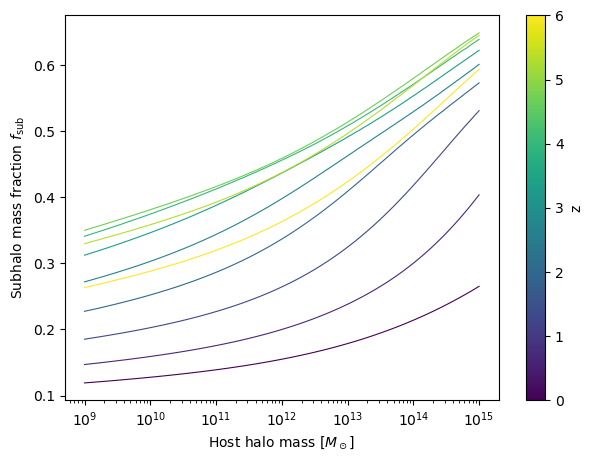

In [54]:
fig, ax = plt.subplots(figsize=(7,5))
fsh_list_num = np.empty((nM,nz))

ax.set_xscale('log')
ax.set_xlabel(r'Host halo mass $[M_\odot]$')
ax.set_ylabel(r'Subhalo mass fraction $f_{\mathrm{sub}}$')
# Colormap for redshift
cmap = viridis
norm = Normalize(vmin=np.min(z_grid), vmax=np.max(z_grid))

for i,z in enumerate(z_grid):
    fsh_list_num[:,i] = np.array([simpson(m_list[M_id][i] * dNdlnm_list[M_id][i],np.log(m_list[M_id][i])) for M_id in range(nM)])/Mz_grid[:,i]
    ax.plot(M_grid,fsh_list[:,i], color=cmap(norm(z)), lw=0.8)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # required for ScalarMappable
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('z')

plt.show()

In [32]:
Msm_grid = np.zeros((nM,nz))

for M_id in range(nM):
    for z_id in range(nz):
        fsh = fsh_list[M_id,z_id]
        Msm_grid[M_id,z_id] = Mz_grid[M_id,z_id]*(1-fsh)

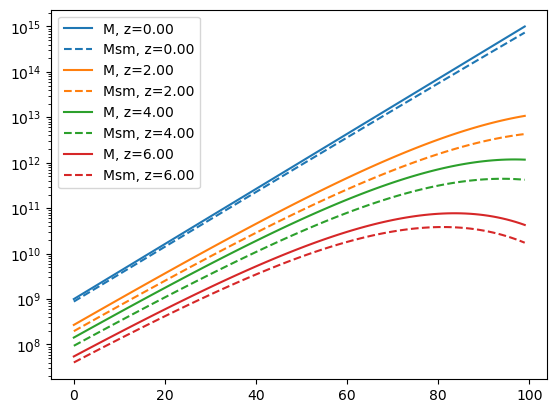

In [62]:
plt.plot(np.arange(nM),Mz_grid[:,0],label=f'M, z={z_grid[0]:.2f}',color = 'C0')
plt.plot(np.arange(nM),Msm_grid[:,0],label=f'Msm, z={z_grid[0]:.2f}',color = 'C0', ls = '--')
plt.plot(np.arange(nM),Mz_grid[:,4],label=f'M, z={z_grid[3]:.2f}',color = 'C1')
plt.plot(np.arange(nM),Msm_grid[:,4],label=f'Msm, z={z_grid[3]:.2f}',color = 'C1', ls = '--')
plt.plot(np.arange(nM),Mz_grid[:,6],label=f'M, z={z_grid[6]:.2f}',color = 'C2')
plt.plot(np.arange(nM),Msm_grid[:,6],label=f'Msm, z={z_grid[6]:.2f}',color = 'C2', ls = '--')
plt.plot(np.arange(nM),Mz_grid[:,9],label=f'M, z={z_grid[9]:.2f}',color = 'C3')
plt.plot(np.arange(nM),Msm_grid[:,9],label=f'Msm, z={z_grid[9]:.2f}',color = 'C3', ls = '--')
plt.yscale('log')
plt.legend()

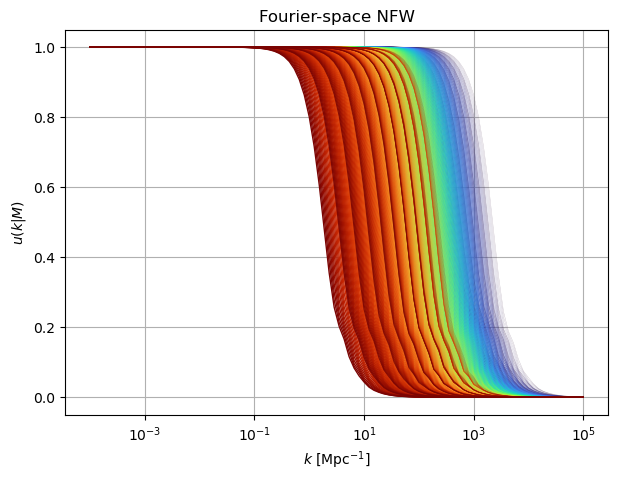

In [63]:
fig, ax = plt.subplots(figsize=(7,5))
colors = plt.cm.turbo(np.linspace(0, 1, nM))

for i in range(nM):
    ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$')
    ax.set_ylabel(r'$u(k|M)$')

    color = colors[i]
    for j,z in enumerate(z_grid):
        alpha = 1 - j / len(z_grid) * 0.8
        lw = 1 - j / len(z_grid) * 0.8
        m = Mz_grid[i,j]
        ax.plot(k_grid, u_kmz[:,i,j], '-',color=color, alpha=alpha, lw=lw)
        ax.set_xscale('log')
    ax.plot([], [], '-', color=color, label=f'$M={m:.0e}$')

#ax.legend(title='Halo mass', loc='lower left')    
plt.title('Fourier-space NFW')
plt.grid()
plt.show()

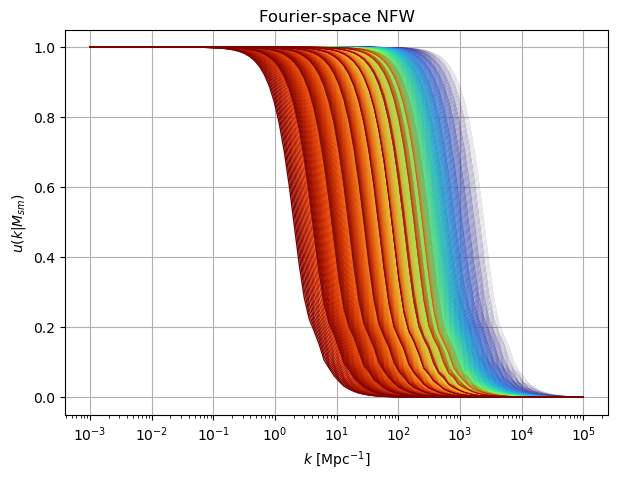

In [72]:
fig, ax = plt.subplots(figsize=(7,5))
colors = plt.cm.turbo(np.linspace(0, 1, nM))

usm_kmz = np.zeros((nk,nM,nz))

for i in range(nM):
    ax.set_xlabel(r'$k\ [{\rm Mpc}^{-1}]$')
    ax.set_ylabel(r'$u(k|M_{sm})$')

    color = colors[i]
    for j,z in enumerate(z_grid):
        alpha = 1 - j / len(z_grid) * 0.8
        lw = 1 - j / len(z_grid) * 0.8
        Msm = Msm_grid[i,j]
        c200, r200, rs = c200_r200_rs(Msm, z=z, hm=hm)
        u = u_nfw(k_grid, c200, rs)
        usm_kmz[:, i, j] = u   
        ax.plot(k_grid, usm_kmz[:,i,j], '-',color=color, alpha=alpha, lw=lw)
        ax.set_xscale('log')
    #ax.plot([], [], '-', color=color, label=f'$Msm={m:.0e}$')

#ax.legend(title='Smooth Mass', loc='lower left')    
plt.title('Fourier-space NFW')
plt.grid()
plt.show()

In [73]:
P_1ss = np.zeros((nz, nk))
P_1sc = np.zeros((nz, nk))
P_1cc = np.zeros((nz, nk))
P_1self_c = np.zeros((nz, nk))

for z_id in range(nz):
    for k_id in range(nk):
        M = Mz_grid[:, z_id]
        Ms = Msm_grid[:, z_id]

        dndlnM = mass_function.massFunction(
            M*c.h, z_grid[z_id], mdef='200m', model='tinker08', q_out='dndlnM'
        )/c.h**3

        u = u_kmz[k_id, :, z_id]
        usm = usm_kmz[k_id, :, z_id]

        I = I_list[k_id, :, z_id]
        J = J_list[k_id, :, z_id]

        dlogMz_dlogM = np.gradient(np.log(M), np.log(M_grid))

        A = (M / rho_b[z_id])**2 * dndlnM * dlogMz_dlogM

        integrand_ss = A * (Ms / M)**2 * usm**2
        integrand_sc = A * Ms / M * usm * u * I
        integrand_cc = A * u**2 * I**2
        integrand_self_c = A * J

        P_1ss[z_id, k_id] = simpson(integrand_ss, np.log(Mz_grid[:, z_id]))
        P_1sc[z_id, k_id] = 2 * simpson(integrand_sc, np.log(Mz_grid[:, z_id]))
        P_1cc[z_id, k_id] = simpson(integrand_cc, np.log(Mz_grid[:, z_id]))
        P_1self_c[z_id, k_id] = simpson(integrand_self_c, np.log(Mz_grid[:, z_id]))

P_1h_total = P_1ss + P_1sc + P_1cc + P_1self_c


In [74]:
P_2ss = np.zeros((nz, nk))
P_2sc = np.zeros((nz, nk))
P_2cc = np.zeros((nz, nk))

for z_id in range(nz):
    for k_id in range(nk):
        M = Mz_grid[:, z_id]
        Ms = Msm_grid[:, z_id]

        dndlnM = mass_function.massFunction(
            M*c.h, z_grid[z_id], mdef='200m', model='tinker08', q_out='dndlnM'
        )/c.h**3

        b = bias.haloBias(M*c.h, z_grid[z_id], '200m', model='tinker10')

        I = I_list[k_id, :, z_id]

        u = u_kmz[k_id, :, z_id]
        usm = usm_kmz[k_id, :, z_id]

        dlogMz_dlogM = np.gradient(np.log(M), np.log(M_grid))

        A = (M / rho_b[z_id]) * dndlnM * dlogMz_dlogM

        Plin = P_lin_zk[z_id,k_id]

        integrand_S = A * b * (Ms / M) * usm
        integrand_C = A * b * u * usm * I

        S = simpson(integrand_S, np.log(Mz_grid[:, z_id]))
        C = simpson(integrand_C, np.log(Mz_grid[:, z_id]))

        P_2ss[z_id, k_id] = Plin * S ** 2
        P_2sc[z_id, k_id] = 2 * Plin * S * C
        P_2cc[z_id, k_id] = Plin * C ** 2

P_2h_total = P_2ss + P_2sc + P_2cc 

In [75]:
P_hh_total_sub = P_1h_total + P_2h_total

In [76]:
np.savez('halo_model_power_spectra_substructure04.npz', k=k_grid, z=z_grid, P_1ss=P_1ss, P_1sc=P_1sc, P_1cc=P_1cc, P_1self_c=P_1self_c, P_1h_total=P_1h_total,P_2ss=P_2ss, P_2sc=P_2sc, P_2cc=P_2cc, P_2h_total=P_2h_total,P_hh_total=P_hh_total_sub)

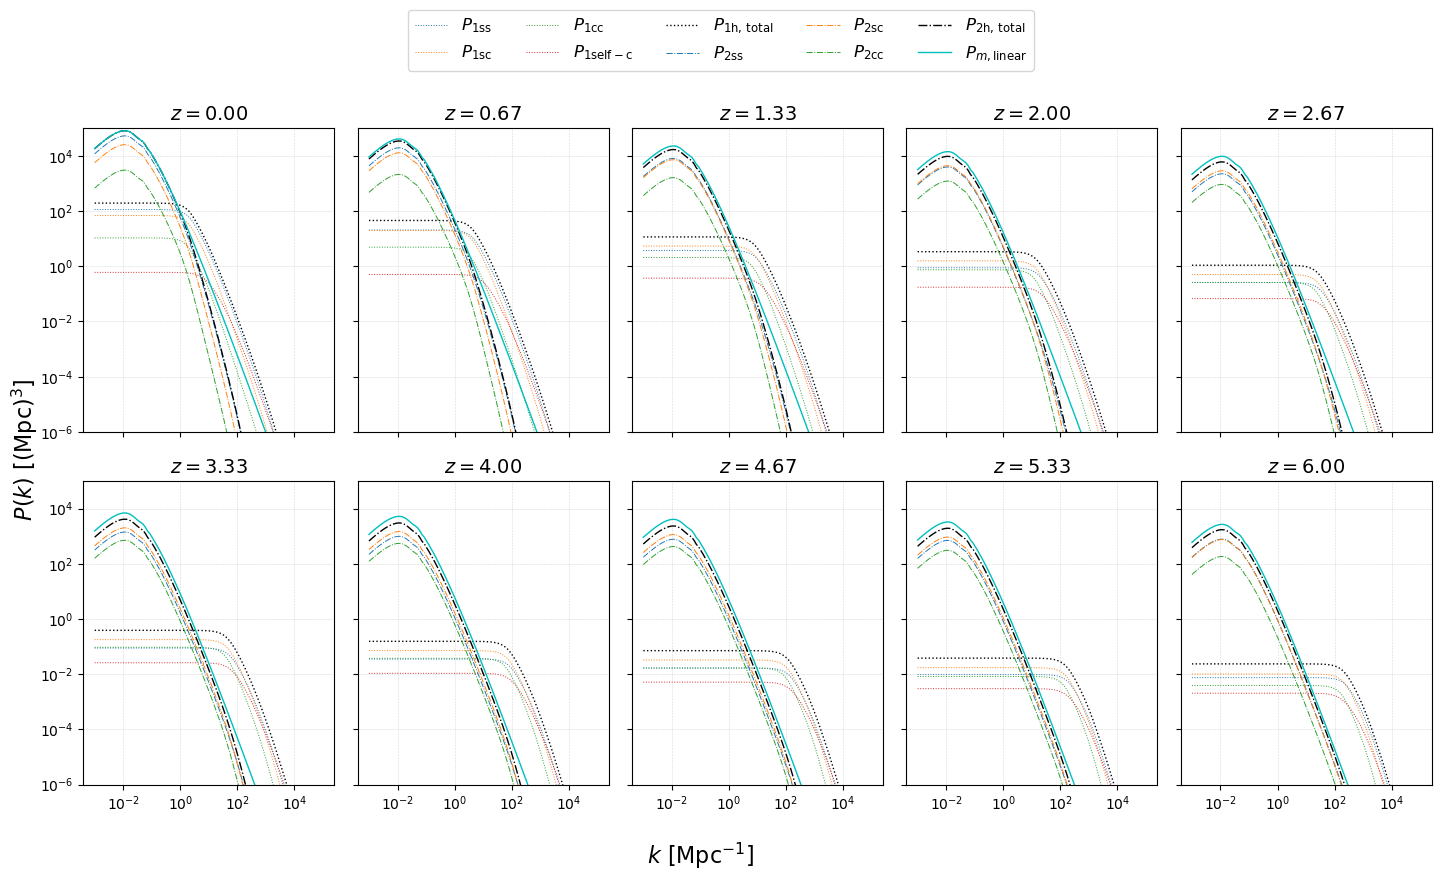

In [77]:
fig, axes = plt.subplots(2, 5, figsize=(15, 9), sharex=True, sharey=True)
axes = axes.flatten()

for i, z in enumerate(z_grid):
    ax = axes[i]

    # --- Plot each 1-halo component ---
    ax.plot(k_grid, P_1ss[i,:],     color='C0', ls=':',linewidth = 0.7,     label=r"$P_{1\mathrm{ss}}$")
    ax.plot(k_grid, P_1sc[i,:],     color='C1', ls=':',linewidth = 0.7,     label=r"$P_{1\mathrm{sc}}$")
    ax.plot(k_grid, P_1cc[i,:],     color='C2', ls=':',linewidth = 0.7,     label=r"$P_{1\mathrm{cc}}$")
    ax.plot(k_grid, P_1self_c[i,:], color='C3', ls=':',linewidth = 0.7, label=r"$P_{1\mathrm{self-c}}$")

    # --- Total 1-halo ---
    ax.plot(k_grid, P_1h_total[i,:], color='black', ls=':',linewidth = 1, label=r"$P_{1\mathrm{h,\,total}}$")

    # --- Plot each 2-halo component ---
    ax.plot(k_grid, P_2ss[i,:],     color='C0', ls='-.',linewidth = 0.7,     label=r"$P_{2\mathrm{ss}}$")
    ax.plot(k_grid, P_2sc[i,:],     color='C1', ls='-.',linewidth = 0.7,     label=r"$P_{2\mathrm{sc}}$")
    ax.plot(k_grid, P_2cc[i,:],     color='C2', ls='-.',linewidth = 0.7,     label=r"$P_{2\mathrm{cc}}$")

    # --- Total 2-halo ---
    ax.plot(k_grid, P_2h_total[i,:], color='black', ls='-.',linewidth = 1, label=r"$P_{2\mathrm{h,\,total}}$")

    # --- standard 1-halo and 2-halo ---
    #ax.plot(k_grid, P_1h[i,:], ls='-', color='m', linewidth = 0.7,label=r"$P_{1\mathrm{h}}$ (standard)")
    #ax.plot(k_grid, P_2h[i,:], ls='-', color='m', linewidth = 0.7, label=r"$P_{2\mathrm{h}}$ (standard)")

    # --- Linear power spectrum ---
    ax.plot(k_grid, P_lin_zk[i,:], ls='-', color='c',linewidth = 1, label=r"$P_{m\mathrm{,linear}}$")


    # --- Axis formatting ---
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-6, 1e5)
    ax.set_title(fr"$z = {z:.2f}$", fontsize=14)
    ax.grid(True, which="both", ls="--", lw=0.4, alpha=0.5)

# --- Turn off any unused panels (none here) ---
for j in range(len(z_grid), len(axes)):
    axes[j].axis("off")

# --- Shared axis labels ---
fig.text(0.5, 0.04, r"$k\ [{\rm Mpc}^{-1}]$", ha="center", fontsize=16)
fig.text(0.04, 0.5, r"$P_{\rm}(k)\ [(\mathrm{Mpc})^3]$", va="center",
         rotation="vertical", fontsize=16)

# --- One clean shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5,
           fontsize=12, frameon=True, borderaxespad=0.6)

plt.tight_layout(rect=[0.05, 0.08, 1, 0.90])
plt.show()


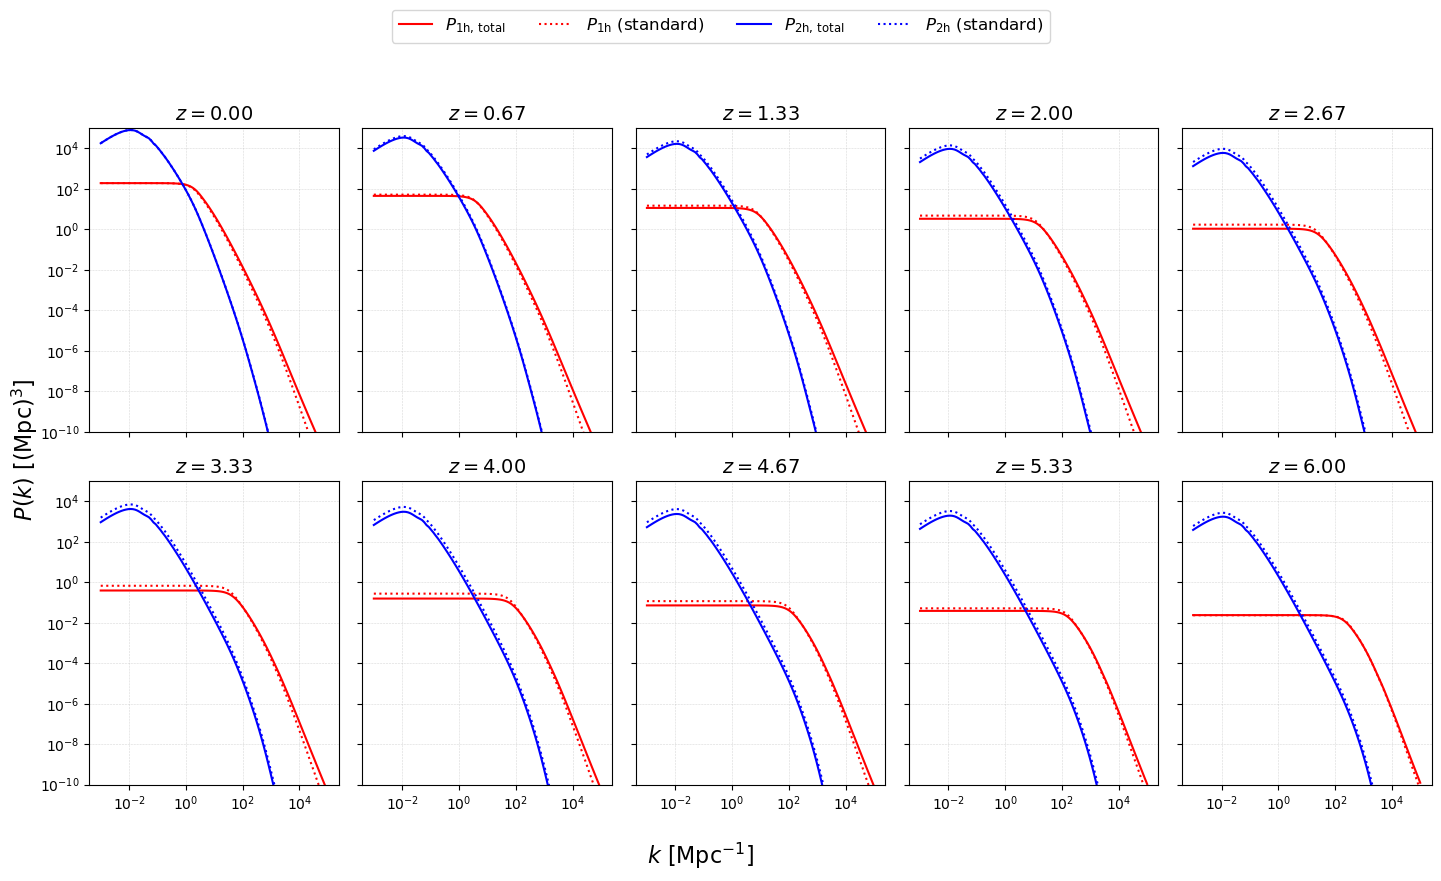

In [78]:
fig, axes = plt.subplots(2, 5, figsize=(15, 9), sharex=True, sharey=True)
axes = axes.flatten()

for i, z in enumerate(z_grid):
    ax = axes[i]

    # --- Total 1-halo ---
    ax.plot(k_grid, P_1h_total[i,:], color='r', ls='-', label=r"$P_{1\mathrm{h,\,total}}$")

    # --- standard 1-halo  ---
    ax.plot(k_grid, P_1h[i,:], ls=':', color='r', label=r"$P_{1\mathrm{h}}$ (standard)")

        # --- Total 2-halo ---
    ax.plot(k_grid, P_2h_total[i,:], color='b', ls='-', label=r"$P_{2\mathrm{h,\,total}}$")

    # --- standard 2-halo  ---
    ax.plot(k_grid, P_2h[i,:], ls=':', color='b', label=r"$P_{2\mathrm{h}}$ (standard)")

    # --- Axis formatting ---
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-10, 1e5)
    ax.set_title(fr"$z = {z:.2f}$", fontsize=14)
    ax.grid(True, which="both", ls="--", lw=0.4, alpha=0.5)

# --- Turn off any unused panels (none here) ---
for j in range(len(z_grid), len(axes)):
    axes[j].axis("off")

# --- Shared axis labels ---
fig.text(0.5, 0.04, r"$k\ [{\rm Mpc}^{-1}]$", ha="center", fontsize=16)
fig.text(0.04, 0.5, r"$P_{\rm}(k)\ [(\mathrm{Mpc})^3]$", va="center",
         rotation="vertical", fontsize=16)

# --- One clean shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5,
           fontsize=12, frameon=True, borderaxespad=0.6)

plt.tight_layout(rect=[0.05, 0.08, 1, 0.90])
plt.show()

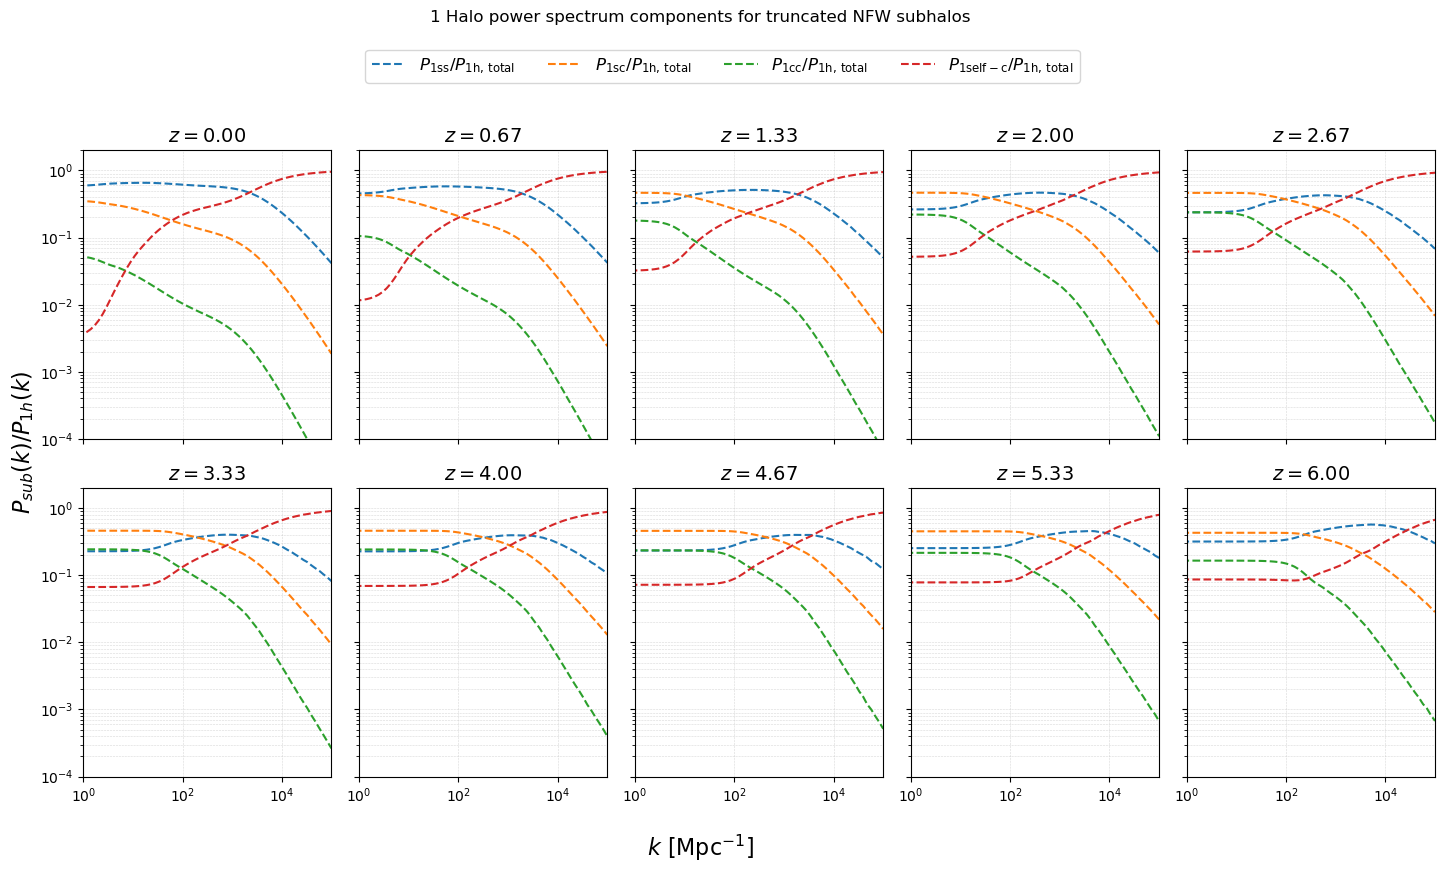

In [79]:
fig, axes = plt.subplots(2, 5, figsize=(15, 9), sharex=True, sharey=True)
fig.suptitle('1 Halo power spectrum components for truncated NFW subhalos')

axes = axes.flatten()

for i, z in enumerate(z_grid):
    ax = axes[i]

    # --- Plot each 1-halo component ---
    ax.plot(k_grid, P_1ss[i,:]/P_1h_total[i,:],     color='C0', ls='--',     label=r"$P_{1\mathrm{ss}}/P_{1\mathrm{h,\,total}}$")
    ax.plot(k_grid, P_1sc[i,:]/P_1h_total[i,:],     color='C1', ls='--',     label=r"$P_{1\mathrm{sc}}/P_{1\mathrm{h,\,total}}$")
    ax.plot(k_grid, P_1cc[i,:]/P_1h_total[i,:],     color='C2', ls='--',     label=r"$P_{1\mathrm{cc}}/P_{1\mathrm{h,\,total}}$")
    ax.plot(k_grid, P_1self_c[i,:]/P_1h_total[i,:], color='C3', ls='--', label=r"$P_{1\mathrm{self-c}}/P_{1\mathrm{h,\,total}}$")

    # --- Axis formatting ---
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-4, 2)
    ax.set_xlim(1e0, 1e5)
    ax.set_title(fr"$z = {z:.2f}$", fontsize=14)
    ax.grid(True, which="both", ls="--", lw=0.4, alpha=0.5)

# --- Turn off any unused panels (none here) ---
for j in range(len(z_grid), len(axes)):
    axes[j].axis("off")

# --- Shared axis labels ---
fig.text(0.5, 0.04, r"$k\ [{\rm Mpc}^{-1}]$", ha="center", fontsize=16)
fig.text(0.04, 0.5, r'$P_{sub}(k) /P_{1h}(k)$', va="center",
         rotation="vertical", fontsize=16)

# --- One clean shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5,
           fontsize=12, frameon=True, borderaxespad=3)

plt.tight_layout(rect=[0.05, 0.08, 1, 0.90])
plt.show()

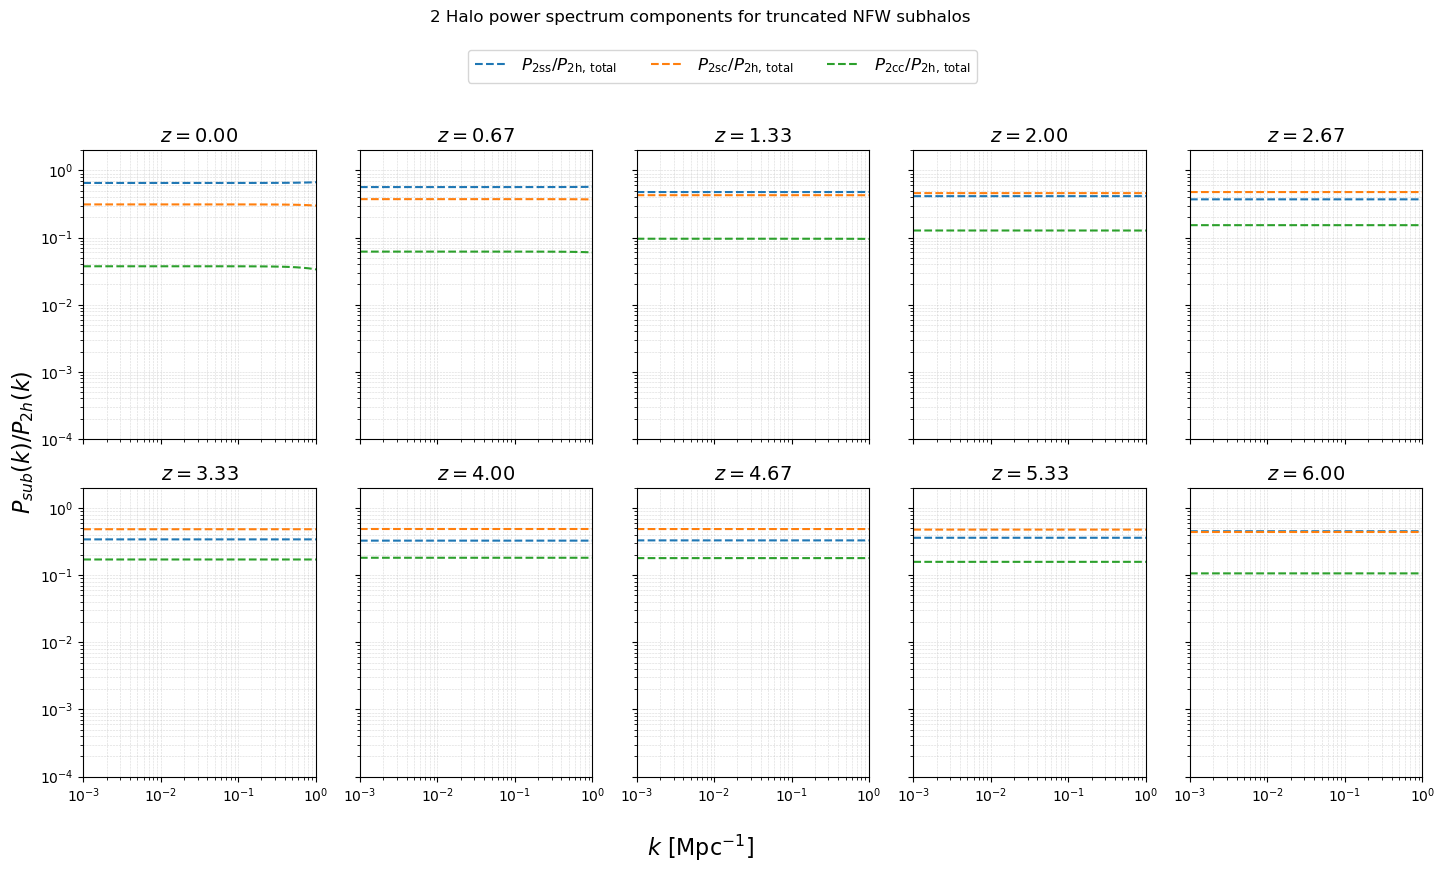

In [80]:
fig, axes = plt.subplots(2, 5, figsize=(15, 9), sharex=True, sharey=True)
fig.suptitle('2 Halo power spectrum components for truncated NFW subhalos')

axes = axes.flatten()

for i, z in enumerate(z_grid):
    ax = axes[i]

    # --- Plot each 2-halo component ---
    ax.plot(k_grid, P_2ss[i,:]/P_2h_total[i,:],     color='C0', ls='--',     label=r"$P_{2\mathrm{ss}}/P_{2\mathrm{h,\,total}}$")
    ax.plot(k_grid, P_2sc[i,:]/P_2h_total[i,:],     color='C1', ls='--',     label=r"$P_{2\mathrm{sc}}/P_{2\mathrm{h,\,total}}$")
    ax.plot(k_grid, P_2cc[i,:]/P_2h_total[i,:],     color='C2', ls='--',     label=r"$P_{2\mathrm{cc}}/P_{2\mathrm{h,\,total}}$")

    # --- Axis formatting ---
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim(1e-4, 2)
    ax.set_xlim(1e-3,1e0)
    ax.set_title(fr"$z = {z:.2f}$", fontsize=14)
    ax.grid(True, which="both", ls="--", lw=0.4, alpha=0.5)

# --- Turn off any unused panels (none here) ---
for j in range(len(z_grid), len(axes)):
    axes[j].axis("off")

# --- Shared axis labels ---
fig.text(0.5, 0.04, r"$k\ [{\rm Mpc}^{-1}]$", ha="center", fontsize=16)
fig.text(0.04, 0.5, r'$P_{sub}(k) /P_{2h}(k)$', va="center",
         rotation="vertical", fontsize=16)

# --- One clean shared legend ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=5,
           fontsize=12, frameon=True, borderaxespad=3)

plt.tight_layout(rect=[0.05, 0.08, 1, 0.90])
plt.show()